In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


### Plot the number of ratings per movie and user

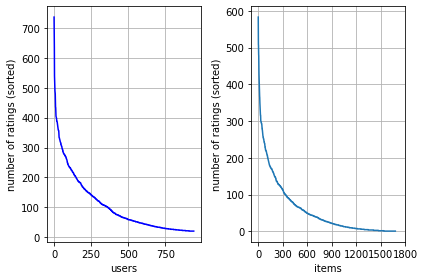

min # of items per user = 20, min # of users per item = 1.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
#     valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
#     valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings=ratings # don't drop anything
#     valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

the shape of original ratings. (# of row, # of col): (1682, 943)
the shape of valid ratings. (# of row, # of col): (1152, 943)


ValueError: shape mismatch in assignment

## Implementing Baselines 

### Use the global mean to do the prediction

In [6]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    # find the non zero ratings in the train
    nonzero_train = train[train.nonzero()]

    # calculate the global mean
    global_mean_train = nonzero_train.mean()

    # find the non zero ratings in the test
    nonzero_test = test[test.nonzero()].todense()

    # predict the ratings as global mean
    mse = calculate_mse(nonzero_test, global_mean_train)
    rmse = np.sqrt(1.0 * mse / nonzero_test.shape[1])
    print("test RMSE of baseline using the global mean: {v}.".format(v=rmse))

baseline_global_mean(train, test)

test RMSE of baseline using the global mean: [[ 1.12489888]].


### Use the user means as the prediction

In [7]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape

    for user_index in range(num_users):
        # find the non-zero ratings for each user in the training dataset
        train_ratings = train[:, user_index]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            user_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each user in the test dataset
        test_ratings = test[:, user_index]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, user_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the user mean: {v}.".format(v=rmse))

baseline_user_mean(train, test)

test RMSE of the baseline using the user mean: [[ 1.05356297]].


### Use the item means as the prediction

In [8]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    for item_index in range(num_items):
        # find the non-zero ratings for each item in the training dataset
        train_ratings = train[item_index, :]
        nonzeros_train_ratings = train_ratings[train_ratings.nonzero()]

        # calculate the mean if the number of elements is not 0
        if nonzeros_train_ratings.shape[0] != 0:
            item_train_mean = nonzeros_train_ratings.mean()
        else:
            continue
        
        # find the non-zero ratings for each movie in the test dataset
        test_ratings = test[item_index, :]
        nonzeros_test_ratings = test_ratings[test_ratings.nonzero()].todense()
        
        # calculate the test error 
        mse += calculate_mse(nonzeros_test_ratings, item_train_mean)
    rmse = np.sqrt(1.0 * mse / test.nnz)
    print("test RMSE of the baseline using the item mean: {v}.".format(v=rmse))
    
baseline_item_mean(train, test)

test RMSE of the baseline using the item mean: [[ 1.01449251]].


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [15]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_item, num_user = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [16]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        mse += (data[row, col] - user_info.T.dot(item_info)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [20]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            err = train[d, n] - user_info.T.dot(item_info)
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.081497632563063.
iter: 1, RMSE on training set: 1.029803849784576.
iter: 2, RMSE on training set: 1.0019809035101255.
iter: 3, RMSE on training set: 0.9853666299258862.
iter: 4, RMSE on training set: 0.9750716860449808.
iter: 5, RMSE on training set: 0.9704009306183263.
iter: 6, RMSE on training set: 0.9669991741568986.
iter: 7, RMSE on training set: 0.9630762628484878.
iter: 8, RMSE on training set: 0.9615511910698763.
iter: 9, RMSE on training set: 0.9589299480929678.
iter: 10, RMSE on training set: 0.959732333780623.
iter: 11, RMSE on training set: 0.9582914490852443.
iter: 12, RMSE on training set: 0.9577931080789052.
iter: 13, RMSE on training set: 0.9575839427031514.
iter: 14, RMSE on training set: 0.9571950816510866.
iter: 15, RMSE on training set: 0.9562654534229875.
iter: 16, RMSE on training set: 0.9559287414630159.
iter: 17, RMSE on training set: 0.9561185200623608.
iter: 18, RMSE on training set: 0

### Learn the Matrix Factorization using Alternating Least Squares

In [29]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""
    num_user = nnz_items_per_user.shape[0]
    num_feature = item_features.shape[0]
    lambda_I = lambda_user * sp.eye(num_feature)
    updated_user_features = np.zeros((num_feature, num_user))

    for user, items in nz_user_itemindices:
        # extract the columns corresponding to the prediction for given item
        M = item_features[:, items]
        
        # update column row of user features
        V = M @ train[items, user]
        A = M @ M.T + nnz_items_per_user[user] * lambda_I
        X = np.linalg.solve(A, V)
        updated_user_features[:, user] = np.copy(X.T)
    return updated_user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""
    num_item = nnz_users_per_item.shape[0]
    num_feature = user_features.shape[0]
    lambda_I = lambda_item * sp.eye(num_feature)
    updated_item_features = np.zeros((num_feature, num_item))

    for item, users in nz_item_userindices:
        # extract the columns corresponding to the prediction for given user
        M = user_features[:, users]
        V = M @ train[item, users].T
        A = M @ M.T + nnz_users_per_item[item] * lambda_I
        X = np.linalg.solve(A, V)
        updated_item_features[:, item] = np.copy(X.T)
    return updated_item_features

In [30]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # get the number of non-zero ratings for each user and item
    nnz_items_per_user, nnz_users_per_item = train.getnnz(axis=0), train.getnnz(axis=1)
    
    # group the indices by row or column index
    nz_train, nz_item_userindices, nz_user_itemindices = build_index_groups(train)

    # run ALS
    print("\nstart the ALS algorithm...")
    while change > stop_criterion:
        # update user feature & item feature
        user_features = update_user_feature(
            train, item_features, lambda_user,
            nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(
            train, user_features, lambda_item,
            nnz_users_per_item, nz_item_userindices)

        error = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(error))
        error_list.append(error)
        change = np.fabs(error_list[-1] - error_list[-2])

    # evaluate the test error
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("test RMSE after running ALS: {v}.".format(v=rmse))

ALS(train, test)


start the ALS algorithm...
RMSE on training set: 1.9127836193917878.
RMSE on training set: 1.161584665057034.
RMSE on training set: 1.0415094612421196.
RMSE on training set: 0.9930375983713047.
RMSE on training set: 0.9690284075235571.
RMSE on training set: 0.9556714892005632.
RMSE on training set: 0.9476261066311378.
RMSE on training set: 0.9425014892677404.
RMSE on training set: 0.9391068535761989.
RMSE on training set: 0.9367959149557584.
RMSE on training set: 0.9351925819501763.
RMSE on training set: 0.9340654686318525.
RMSE on training set: 0.933265907448913.
RMSE on training set: 0.932695173827355.
RMSE on training set: 0.9322860749095511.
RMSE on training set: 0.9319920437189873.
RMSE on training set: 0.9317803800771869.
RMSE on training set: 0.931627901871879.
RMSE on training set: 0.9315180619189877.
RMSE on training set: 0.93143899116918.
test RMSE after running ALS: 0.9704191683650746.
